# 0. Setup Paths

In [19]:
import os

In [20]:
CUSTOM_MODEL_NAME = 'Custom_SSDmobilenet_Various_OIDV6' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [21]:
paths = {
    'WORKSPACE_PATH': os.path.join('training_models'),
    'SCRIPTS_PATH': os.path.join('training_models','scripts'),
    'APIMODEL_PATH': os.path.normpath(r"E:\Kuliah\Bangkit\Capstone\Tensorflow\tfodapi"),
    'ANNOTATION_PATH': os.path.join('training_models','annotations'), #Not Used
    'IMAGE_PATH': os.path.join('training_models','test-images'),
    'MODEL_PATH': os.path.join('training_models','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('training_models','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('training_models','models',CUSTOM_MODEL_NAME), 
    #'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
 }

In [22]:
files = {
    'PIPELINE_CONFIG':os.path.join('training_models','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# 4. Copy Model Config to Training Folder

In [44]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !mkdir {os.path.join(paths['CHECKPOINT_PATH'])}
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'], "pipeline.config")}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [8]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [46]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [48]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

# Configure Dataset to Use

In [5]:
Train = []
Test = []

In [6]:
#CirebonLP_with_EnglisLP-Caltech

Raw_Train = [r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\Caltech.tfrecord",r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\Cirebon-Train.tfrecord"]
Raw_Test = [r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\AOLP_LE.tfrecord",
        r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\AOLP_RP.tfrecord",
        r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\AOLP_AC.tfrecord",
        r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\Cirebon-Test.tfrecord"]
for path in Raw_Train :
    Train.append(os.path.normpath(path))
for path in Raw_Test :
    Test.append(os.path.normpath(path))

In [346]:
# Various_OIDV6

# Raw_Train = [r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\EuropeLP_Train.tfrecord",
#              r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\Caltech.tfrecord",
#              "E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\OID-LP-2-Val.tfrecord"]

# Raw_Test =[r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\AOLP_LE.tfrecord",
# r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\AOLP_RP.tfrecord",
# r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\AOLP_AC.tfrecord",
# r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\EnglishLP.tfrecord"]

# for path in Raw_Train :
#     Train.append(os.path.normpath(path))
# for path in Raw_Test :
#     Test.append(os.path.normpath(path))

In [347]:
# Cirebon Only

# Raw_Train = [r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\Cirebon-Train.tfrecord"]

# Raw_Test =[r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\LP Only\Cirebon-Test.tfrecord"]

# for path in Raw_Train :
#     Train.append(os.path.normpath(path))
# for path in Raw_Test :
#     Test.append(os.path.normpath(path))

In [138]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= os.path.normpath(r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\OID-LP-2.pbtxt")
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = Train
pipeline_config.eval_input_reader[0].label_map_path = os.path.normpath(r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\OID-LP-2.pbtxt")
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = Test

In [139]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Generate Script to Train Model

In [31]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [32]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [33]:
print(command)

python E:\Kuliah\Bangkit\Capstone\Tensorflow\tfodapi\research\object_detection\model_main_tf2.py --model_dir=training_models\models\Custom_SSDmobilenet_Various_OIDV6 --pipeline_config_path=training_models\models\Custom_SSDmobilenet_Various_OIDV6\pipeline.config --num_train_steps=10000


In [ ]:
!{command}

# Script to Evaluate the Model

In [34]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [35]:
print(command)

python E:\Kuliah\Bangkit\Capstone\Tensorflow\tfodapi\research\object_detection\model_main_tf2.py --model_dir=training_models\models\Custom_SSDmobilenet_Various_OIDV6 --pipeline_config_path=training_models\models\Custom_SSDmobilenet_Various_OIDV6\pipeline.config --checkpoint_dir=training_models\models\Custom_SSDmobilenet_Various_OIDV6


In [36]:
!{command}

^C


# Load Model From Checkpoint

In [23]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [24]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [25]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-9')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [26]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import glob
%matplotlib inline

In [27]:
files['LABELMAP']

'training_models\\annotations\\label_map.pbtxt'

In [28]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [29]:
IMAGE_PATH_1 = glob.glob(r"E:\Kuliah\Bangkit\Capstone\Tensorflow\training_models\test-images\WA-Crop\*.jpg")
IMAGE_PATH_2 = glob.glob(r"E:\Kuliah\Bangkit\Capstone\Tensorflow\training_models\test-images\WA-Crop\*.jpeg")
# Train_Image = glob.glob(r"E:\Kuliah\Bangkit\Capstone\Dataset\CirebonLP\Filtered\*.jpg")

In [30]:
IMAGE_PATH = IMAGE_PATH_1 + IMAGE_PATH_2

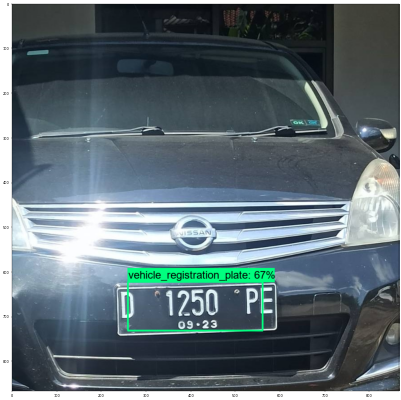

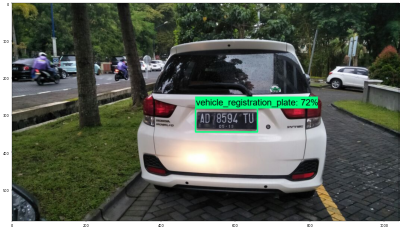

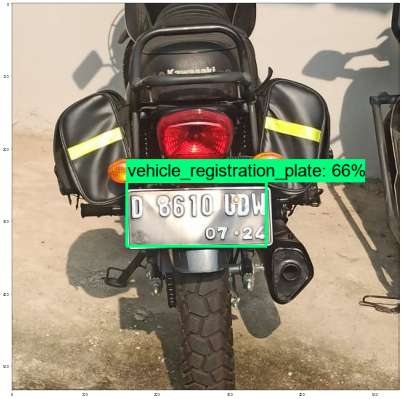

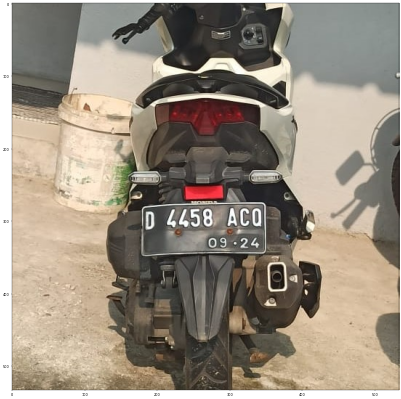

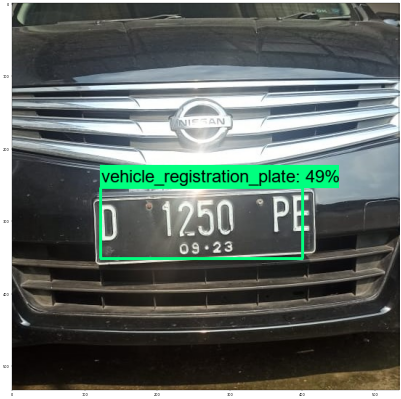

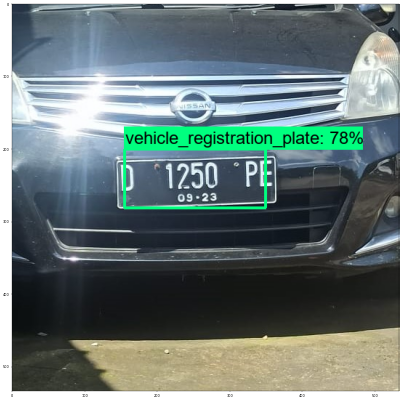

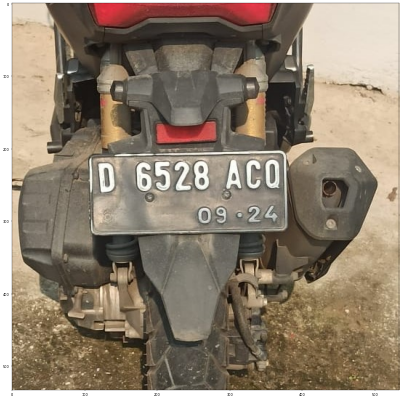

In [31]:
for image in IMAGE_PATH :
    img = cv2.imread(image)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.4,
                agnostic_mode=False)
    plt.figure(figsize=(20, 25),dpi=25)
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

In [118]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

# Apply OCR to Detection

In [33]:
!pip install easyocr

  Using cached scikit_image-0.18.1-cp38-cp38-win_amd64.whl (12.2 MB)
  Using cached imageio-2.9.0-py3-none-any.whl (3.3 MB)
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached PyWavelets-1.1.1-cp38-cp38-win_amd64.whl (4.3 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Uninstalling decorator-5.0.9:
      Successfully uninstalled decorator-5.0.9


In [34]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.9.1
    Uninstalling torchvision-0.9.1:
      Successfully uninstalled torchvision-0.9.1


In [39]:
import easyocr

OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\gagah\Anaconda3\envs\tf220\lib\site-packages\torch\lib\cublas64_11.dll" or one of its dependencies.

In [ ]:
detection_threshold = 0.7

In [ ]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [ ]:
width = image.shape[1]
height = image.shape[0]

In [ ]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [ ]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

# OCR Filtering

In [ ]:
region_threshold = 0.05

In [ ]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [ ]:
filter_text(region, ocr_result, region_threshold)

# Bring it Together

In [ ]:
region_threshold = 0.6

In [ ]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

In [ ]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Save Results

In [ ]:
import csv
import uuid

In [ ]:
'{}.jpg'.format(uuid.uuid1())

In [ ]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [ ]:
region

In [ ]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')